##### Bastien AVRILLON et Guillaume GIESSNER (Groupe n°4)

# <center>Mini-projet 4 d'Optimisation - RESTAURATION D'IMAGES</center>

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
import math

from scipy.ndimage import gaussian_filter #Pk ?

## 1 - Étude du problème d'optimisation

#### Question 1 -

Les variables de décisions sont les $N = n \times m$ pixel de l'images qui forment donc un vecteur $z \in \mathbb{R}^{n \times m}$. Par commodité, on indice ces variables par leur position dans l'image, en voyant $z$ comme une matrice de $\mathcal{M}_{n \times m}(\mathbb{R})$.

Le problème de restauration d’image consiste à minimiser la fonction coût suivante :

$\begin{aligned}
f \colon \mathbb{R}^{n \times m} \to \mathbb{R} \\
z \mapsto f(z) & = \dfrac{1}{2} \| z - u_b \|_2^2 + \sum_{i,j} \| \nabla z(i,j) \|_2^2 \\
                &= \sum_{1 \leq i \leq n \; , \; 1 \leq j \leq m} \dfrac{1}{2} (z(i,j) - u_b(i,j))^2 \\
                &+ \sum_{1 \leq j < m} \left( z(n, j+1) - z(n, j) \right)^2 \\ 
                &+ \sum_{1 \leq i < n} \left( z(i+1, m) - z(i, m) \right)^2 \\
                &+ \sum_{\substack{1 \leq i < n \\ 1 \leq j < m}} \left( z(i+1, j) - z(i, j) \right)^2 + \left( z(i, j+1) - z(i, j) \right)^2
\end{aligned}$

On a effectivement  $\|\nabla u(i,j)\|_2^2 = \nabla_x u(i,j)^2 + \nabla_y u(i,j)^2 $, donc :

$ \begin{aligned}
\sum_{i,j} \| \nabla u(i,j) \|_2^2 &= \sum_{1 \leq i \leq n \; , \; 1 \leq j \leq m} \nabla_x u(i,j)^2 + \nabla_y u(i,j)^2 \\
&= \sum_{1 \leq j < n} \left( u(n, j+1) - u(n, j) \right)^2 + 
    \sum_{1 \leq i < n} \left( u(i+1, n) - u(i, n) \right)^2
    \sum_{1 \leq i < n \; , \; 1 \leq j < m} \left( u(i+1, j) - u(i, j) \right)^2 + \left( u(i, j+1) - u(i, j) \right)^2 \end{aligned}$

La contrainte imposée dans la minimisation est définie par :

$\begin{aligned}
c \colon \mathbb{R}^{2n \times m} &\to \mathbb{R}^{2n \times m}  \\
z &\mapsto c(z) = \begin{cases} 
-z(i,j) & \text{si } 1 \leq i \leq n, \\ 
z(i,j) - 1 & \text{si } n + 1 \leq i \leq 2n. 
\end{cases} 
\end{aligned}$


De cette manière, le problème de minimisation devient : $\min\limits_{z \in \mathbb{R}^{n \times m},\ c(z) \leq 0} f(z)$


#### Question 2 -

$ u \mapsto \frac{1}{2} \| u - u_b \|_2^2 $ est une fonction quadratique de matrice héssienne $I_{nm}$ (qui est symétrique positive) donc convexe, 

$ u \mapsto \sum_{i,j} \| \nabla u(i,j) \|_2^2 $ est également convexe, car comme détaillé par le calcul à la question précédente, elle s'écrit comme 3 sommes de termes de la forme $ u \mapsto (u(k,l) - u(p,q))^2 $, qui sont eux-même convexe par composition préservant la convexité de l'application linéaire $ u \mapsto u(k,l) - u(p,q) $ avec la fonction carré qui est convexe sur $\mathbb{R}$.

Ainsi, $f$ est convexe, comme somme de ceux fonctions convexes.

La différentiabilité de cette fonction $f$ provient du fait qu'elle est une fonction polynomiale (en les coordonnées de la base canonique de $\mathbb{R}^{n \times m}$),comme détaillé par le calcul à la question précédente.

#### Question 3 -

On montre que le gradient de la fonction $ f $ est donné par $\nabla f(u) = u - u_b - 2 \text{div}(\nabla u) = u - u_b - 2 \Delta u$

La fonction $ f $ est définie par $f(u) = \frac{1}{2} \|u - u_b\|^2 + \sum_{(i,j)} \|\nabla u(i, j)\|^2$

On a pour le premier terme $\frac{\partial}{\partial u} \left( \frac{1}{2} \|u - u_b\|^2 \right) = \frac{\partial}{\partial u} \left( \frac{1}{2} \sum_{(i,j)} (u(i,j) - u_b(i,j))^2 \right) = u - u_b$

Pour le second $\frac{\partial}{\partial u} \left( \sum_{(i,j)} \|\nabla u(i, j)\|^2 \right) = \frac{\partial}{\partial u} \left( \sum_{(i,j)} (\nabla_x u(i, j))^2 + (\nabla_y u(i, j))^2 \right) = -2 \text{div}(\nabla u)$

En utilisant les définitions discrètes du gradient et de la divergence, nous avons $ \text{div}(\nabla u) = \Delta u $

On obtient finalement bien $ \nabla f(u) = u - u_b - 2 \text{div}(\nabla u) = u - u_b - 2 \Delta u $

## 2 - Résolution numérique

#### Question 4 -

In [5]:
def matrice_to_image(mat):
    mat_prime = mat[:,:,np.newaxis]
    return np.stack([mat]*3, axis=-1)

In [6]:
def matrice_to_vecteur(mat):
    return np.ravel(mat)

def vecteur_to_matrice(vect):
    return(vect.reshape(n,m))

In [7]:
#L'image d'origine est en RGB, on l'importe en noir et blanc avec 1 canal :
img_noise = plt.imread('robot_noise.jpg')[...,0]          
img_no_noise = plt.imread('robot_no_noise.jpg')[...,0]

#L'importation code les pixels sur des entiers de 8bits, on veut des flotants de 32bits :
img_noise = img_noise.astype(np.float32) / 255.0
img_no_noise = img_no_noise.astype(np.float32) / 255.0

In [8]:
n,m = img_noise.shape #Dimension des images

In [9]:
def f(u):
    difference =  u -img_noise
    terme_1 = 0.5*np.linalg.norm(difference.reshape(-1),2)**2
    terme_2 = np.linalg.norm(grad_img(u).ravel(),2)**2
    res = terme_1 + terme_2
    return res

In [10]:
def grad_img(u):                                    #Gradient d'une image
    grad_x = np.zeros_like(u)
    grad_y = np.zeros_like(u)
    grad_x[:-1, :] = u[1:, :] - u[:-1, :]
    grad_y[:, :-1] = u[:, 1:] - u[:, :-1]
    grad_im = np.stack((grad_x, grad_y), axis=-1)
    return grad_im

def divergence(v):                              #Divergence d'une fonction
    div = np.zeros_like(v)[:,:,0]
    div[1:-1,:] += v[1:-1,:,0] - v[:-2, :,0]
    div[:, 1:-1] += v[:,1:-1,1] - v[:,:-2,1]
    div[0,:] += v[0,:,0]
    div[:,0] += v[:,0,1]
    div[-1,:] -= v[-2,:,0]
    div[:,-1] -= v[:,-2,1]
    return div

def laplacien(u):                               #Laplacien d'une image
    grad_im = grad_img(u)
    return divergence(grad_im)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.8431373..2.4431374].


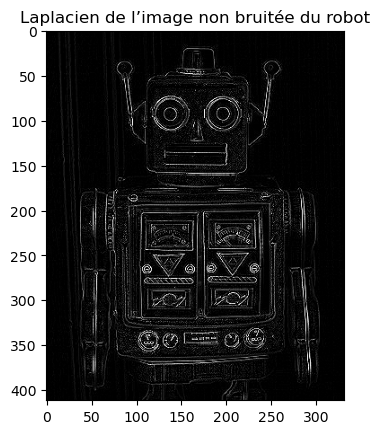

In [11]:
plt.imshow(matrice_to_image(laplacien(img_no_noise)),cmap='gray')
plt.title("Laplacien de l’image non bruitée du robot")
plt.show()

#### Question 5 -

In [12]:
def grad_f(u):
    res = u -img_noise -2*laplacien(u) 
    return res

In [13]:
#Vérification de l'implémentation du gradient de f

def approximation_grad_f(u,h,epsilon):
    return (f(u+epsilon*h)-f(u-epsilon*h))/(2*epsilon)

u1 = img_no_noise
epsilon = 0.00001
h = np.random.rand(n,m)

print(approximation_grad_f(u1,h,epsilon),np.trace(np.dot(np.transpose(grad_f(u1)),h)))

-731.3341187000332 -731.3341520128157


In [14]:
#30s d'exécution

def optim_gradient_fixed_step(grad_fun, x0, l, max_iter = 10000, epsilon_grad_fun = 0.005):
    k = 0
    xk = x0
    grad_f_xk = grad_fun(xk)
    nb_iterations = 0
    while ((k<max_iter) and (np.linalg.norm(grad_f_xk.reshape(-1),1)>epsilon_grad_fun)):
        pk = -grad_f_xk
        xk = xk + l*pk
        grad_f_xk = grad_fun(xk)
        k = k + 1
        nb_iterations += 1
    return xk,nb_iterations

u_optim_fixed_step,nb_iterations = optim_gradient_fixed_step(grad_f, img_noise, 0.05)

print("Nombre d'itérations de l'algorithme : ",nb_iterations)
norme = np.linalg.norm(grad_f(u_optim_fixed_step).reshape(-1),1)
print("Norme du gradient à l'optimal : ",norme)

Nombre d'itérations de l'algorithme :  10000
Norme du gradient à l'optimal :  0.028647592


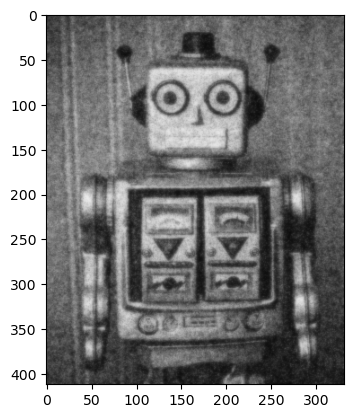

In [15]:
plt.imshow(matrice_to_image(u_optim_fixed_step), cmap='gray')

Commenter......

In [16]:
# Analyse des résultats :

norme_grad_ini = np.linalg.norm((img_noise).reshape(-1),1)
cout_ini = f(img_noise)

norme_grad_fin = np.linalg.norm(grad_f(u_optim_fixed_step).reshape(-1),1)
cout_fin = f(u_optim_fixed_step)

print("Initialement (norme du gradient,cout) : ", norme_grad_ini,cout_ini)
print("Finalement (norme du gradient,cout) : ", norme_grad_fin,cout_fin)

Initialement (norme du gradient,cout) :  55117.09 20810.400112951407
Finalement (norme du gradient,cout) :  0.028647592 2535.783589052622


#### Question 6 -

In [17]:
def RMSE(u):
    difference =  img_no_noise - u 
    numerateur = np.linalg.norm(difference.reshape(-1),2)**2
    denominateur = math.prod(u.shape)
    res = (numerateur/denominateur)**0.5
    return res

print(f"RMSE finale pour l’image trouvée par la minimisation via une méthode de descente de gradient à pas fixe : {RMSE(u_optim_fixed_step)}")
print(f"RMSE pour l'image bruitée d'origine : {RMSE(img_noise)}")

RMSE finale pour l’image trouvée par la minimisation via une méthode de descente de gradient à pas fixe : 0.09647673883877508
RMSE pour l'image bruitée d'origine : 0.1852844596946583


#### Question 7 -

In [18]:
u0 = matrice_to_vecteur(img_noise)

def f_scipy(u):
    return f(vecteur_to_matrice(u))

def grad_f_scipy(u):
    return matrice_to_vecteur(grad_f(vecteur_to_matrice(u)))

In [19]:
#Méthode L-BFGS-B (Quasi-Newton avec une projection permettant de rester dans les bornes fixées):

resultat = optimize.minimize(f_scipy,u0,method='L-BFGS-B',jac=grad_f_scipy)
u_vect_minimisation_scipy = resultat.x
u_minimisation_scipy_BFGS = vecteur_to_matrice(u_vect_minimisation_scipy)
print(resultat)

norme_grad_fin_BFGS = np.linalg.norm(grad_f(u_minimisation_scipy_BFGS).reshape(-1),1)
cout_fin_BFGS = f(u_minimisation_scipy_BFGS)
print("Finalement avec L-BFGS-B (grad,cout) : ", norme_grad_fin_BFGS,cout_fin_BFGS)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 2535.7833600787962
        x: [ 2.590e-01  2.474e-01 ...  9.020e-02  1.039e-01]
      nit: 20
      jac: [ 7.769e-05  3.353e-06 ... -2.125e-05  1.605e-05]
     nfev: 33
     njev: 33
 hess_inv: <136784x136784 LbfgsInvHessProduct with dtype=float64>
Finalement avec L-BFGS-B (grad,cout) :  4.199647070537078 2535.7833980777255


In [20]:
#Méthode CG (Gradient conjugué : sans hésienne et sans contraintes)

resultat = optimize.minimize(f_scipy,u0,method='CG',jac=grad_f_scipy)
u_vect_minimisation_scipy_CG = resultat.x
u_minimisation_scipy_CG = vecteur_to_matrice(u_vect_minimisation_scipy_CG)
print(resultat)

norme_grad_fin_CG = np.linalg.norm(grad_f(u_minimisation_scipy_CG).reshape(-1),1)
cout_fin_CG = f(u_minimisation_scipy_CG)
print("Finalement avec CG (grad,cout) : ", norme_grad_fin_CG,cout_fin_CG)

 message: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: 2535.7833873737945
       x: [ 2.590e-01  2.474e-01 ...  9.021e-02  1.039e-01]
     nit: 16
     jac: [ 1.241e-04 -6.126e-05 ...  2.577e-05  2.388e-05]
    nfev: 56
    njev: 44
Finalement avec CG (grad,cout) :  10.311832 2535.7833873737945


#### Question 8 -

→ Montrons que $TV-L2$ est une fonction convexe.

Définissons les fonction :
$$\begin{aligned}
\beta \colon \mathbb{R}^{n \times m} \to \mathbb{R} \\
u \mapsto \beta(u) & = \dfrac{1}{2} \| u - u_b \|_2^2 \\
\end{aligned}$$
$$\begin{aligned}
\gamma \colon \mathbb{R}^{n \times m} \to \mathbb{R} \\
u \mapsto \gamma(u) & = \sum_{i,j} \| \nabla u(i,j) \|_1 \\
\end{aligned}$$

Telles que $(TV-L2) = \beta + \gamma$. 
On a déjà montré dans à la question 2 que la fonction $\beta$ est convexe. Reste à montrer la convexité de $\gamma$. Explicitons cette fonction :

$\begin{aligned}
\gamma(u) & = \sum_{i,j} \| \nabla u(i,j) \|_1 \\
                &= \sum_{1 \leq j < m} \left| u(n, j+1) - u(n, j) \right| \\ 
                &+ \sum_{1 \leq i < n} \left| u(i+1, m) - u(i, m) \right| \\
                &+ \sum_{\substack{1 \leq i < n \\ 1 \leq j < m}} \left| u(i+1, j) - u(i, j) \right| + \left| u(i, j+1) - u(i, j) \right|
\end{aligned}$

On constate donc que $\gamma$ est une somme de fonctions, chacune d'entre elles étant convexe comme composée d'une fonction linéaire de $\mathbb{R}^{n \times m}$  dans $\mathbb{R}$ par la fonction valeur absolue (qui est convexe) sur $\mathbb{R}^{n \times m}$. On en déduit la convexité de $\gamma$.

**Bilan :** Le problème, défini sur l'ensemble convexe $\mathbb{R}^{n \times m}$ est convexe.


→ Montrons que $TV-L2$ n'est pas différentiable, en raisonnant par l'absurde. 
On suppose donc que cette application $TV-L2$ est différentiable. On reprend les notations précedemment introduites.

On a déjà montré dans à la question 2 que la fonction $\beta$ est différentiable.
Par différence de fonctions différentiable, l'application $\gamma = (TV-L2) - \beta$ est elle aussi différentiable sur $\mathbb{R}^{n \times m}$.

De plus, pout tout $t \in \mathbb{R}$, définissons $u_t = tE_{11}$ la matrice (ou vecteur) dont tous les coefficients sont nuls à l'exception du premier égal à $t$.
On obtient par le calcul : $$ \forall (i,j) \in [\![1, n]\!] \times [\![1, m]\!], \nabla u(i,j) =  \left(-\boldsymbol{\delta}_{1i} \boldsymbol{\delta}_{1j} t,-\boldsymbol{\delta}_{1i} \boldsymbol{\delta}_{1j} t \right)$$

L'application suivante est bien définie et de classe $C^1$ sur $\mathbb{R}$, car chacune de ses fonctions composantes l'est :
$$\begin{aligned}
\psi \colon \mathbb{R} \to \mathbb{R}^{n \times m} \\
t \mapsto \psi(t) &= u_t
\end{aligned}$$

Par composition d'une fonction de $C^1(\mathbb{R},\mathbb{R}^{n \times m})$ et d'une fonction différentiable sur $\mathbb{R}^{n \times m}$, on en déduit que la fonction $h = \gamma \circ \psi$ est définie et dérivable sur $\mathbb{R}$. 

Or $t \in \mathbb{R}, h(t) = \gamma (u_t) = \sum_{i,j} \| \nabla u(i,j) \|_1^2 = \| \nabla u(1,1) \|_1^2 = 2 |t|$, et sachant que la fonction valeur absolue n'est pas dérivable en 0, on en déduit que $h$ ne l'est pas non plus. Ceci est absurde et clôt notre raisonnement, car on a justement démontré la dérivabilité de $h$ sur $\mathbb{R}$.

**Bilan :** ($TV-L2$) n'est pas différentiable, donc le problème n'est pas différentiable.


#### Question 9 -

On montre que le gradient de la fonction $ \text{TV-L2} $ est donné par $ g(u) = u - u_b - \text{div}(\text{sign}(\nabla u)) $

La fonction $ \text{TV-L2} $ est définie par $ \text{TV-L2}(u) = \frac{1}{2} \|u - u_b\|^2 + \sum_{(i,j)} \|\nabla u(i, j)\|_1 $ où $\|\nabla u(i, j)\|_1 = |\nabla_x u(i, j)| + |\nabla_y u(i, j)|$.

On a pour le premier terme $\frac{\partial}{\partial u} \left( \frac{1}{2} \|u - u_b\|^2 \right) = \frac{\partial}{\partial u} \left( \frac{1}{2} \sum_{(i,j)} (u(i,j) - u_b(i,j))^2 \right) = u - u_b $

Pour le second terme, on considère la norme $ L_1 $ du gradient. La dérivée de $\|\nabla u(i, j)\|_1$ n'est pas différentiable partout, mais elle l'est pour x positif et x négatif. Nous pouvons utiliser  $ \frac{\partial}{\partial u} \left( \sum_{(i,j)} \|\nabla u(i, j)\|_1 \right) = \frac{\partial}{\partial u} \left( \sum_{(i,j)} |\nabla_x u(i, j)| + |\nabla_y u(i, j)| \right) = -\text{div}(\text{sign}(\nabla u)) $ où $\text{sign}(x)$ est défini par $
\text{sign}(x) =
\begin{cases}
+1 & \text{si } x > 0 \\
-1 & \text{si } x < 0 \\
0 & \text{si } x = 0
\end{cases}
$

En utilisant les définitions discrètes du gradient et de la divergence, nous avons $ \text{div}(\text{sign}(\nabla u)) = \Delta (\text{sign}(\nabla u)) $

On obtient finalement bien $g(u) = u - u_b - \text{div}(\text{sign}(\nabla u))$

#### Question 10 -

In [21]:
def g(u):
    res = u -img_noise -divergence(grad_img(u)*np.sign(grad_img(u)))
    return res

In [32]:
def optim_sous_gradient(sous_grad_fun, x0, max_iter = 10000, epsilon_variations = 1e-8):
    k = 0
    xk,xk1 = x0,2*x0
    lk = 0.05
    sous_grad_f_xk = sous_grad_fun(xk)
    nb_iterations = 0
    while ((k<max_iter) and (np.linalg.norm((xk1 - xk).reshape(-1),1) / np.linalg.norm(xk.reshape(-1),1) > epsilon_variations)):
        xk = xk1
        pk = -sous_grad_f_xk
        xk1 = xk + lk*pk
        sous_grad_f_xk = sous_grad_fun(xk1)
        k = k + 1
        nb_iterations += 1
        lk = (nb_iterations)**(-0.5)
    return xk,nb_iterations

u_optim_sous_grad,nb_iterations = optim_sous_gradient(g, img_noise)

print("Nombre d'itérations de l'algorithme de sous-gradient : ",nb_iterations)

Nombre d'itérations de l'algorithme de sous-gradient :  786


c:\miniconda\Lib\site-packages\numpy\linalg\linalg.py:2579: RuntimeWarning: overflow encountered in reduce
  return add.reduce(abs(x), axis=axis, keepdims=keepdims)


In [26]:
print(f"RMSE pour l'image bruitée d'origine : {RMSE(img_noise)}")
print(f"Fonction coût trouvée par la minimisation via une méthode de sous-gradient : {f(u_optim_sous_grad)}")

RMSE pour l'image bruitée d'origine : 0.1852844596946583
Fonction coût trouvée par la minimisation via une méthode de sous-gradient : 11594150246048.695


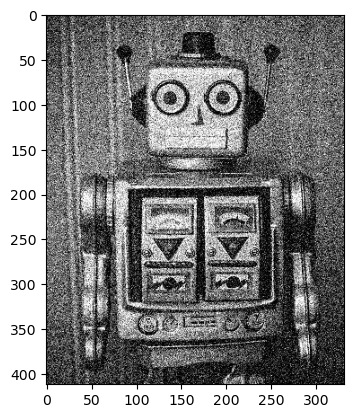

In [24]:
plt.imshow(matrice_to_image(u_optim_sous_grad), cmap='gray')